# Brain Decoding Project Using FMRI

In [1]:
# Run this cell to load data and install libraries
# data download and library installation
# Generic object decoding data
!wget -q -O data.h5 https://ndownloader.figshare.com/files/15049646
# Generic object decoding features
!wget -q -O features.h5 https://ndownloader.figshare.com/files/15015971
# Download ImageNet labels
!wget -q -O imagenet_classes.txt https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

!pip install -q bdpy
!pip install -q seaborn_image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.8/122.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 8.6 MB/s eta 0:00:00


In [10]:
# Importing required libraries
import bdpy
from bdpy.util import get_refdata
import numpy as np
import pandas as pd
import seaborn_image as isns
import seaborn as sns
import ipywidgets as widgets  # interactive display
import matplotlib.pyplot as plt
from random import seed
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import urllib
from PIL import Image
from torchvision import transforms
import torch


In [3]:
rois = {'VC' : 'ROI_VC = 1',
        'LVC' : 'ROI_LVC = 1',
        'HVC' : 'ROI_HVC = 1',
        'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1'}

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_id)
    seed(worker_id)

### Explore data
Now let’s look at real brain data. We will be using data from the paper (horikawa et al paper). The dataset contains a large amount of fMRI data of images shown to subjects. Some of those images are repeatedly shown to the subject while others are shown once but different images having the same main objects (note: those images are not necessarily the ones in the dataset):

Similar: Gold fish category

<img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/> <img src="https://drive.google.com/uc?id=16oO0d0TH-Bk46ThVhcXfwFi8Mkbh1sHu" alt="drawing" height="110"/>

Different: Cat category

<img src="https://drive.google.com/uc?id=1vSehKdq7Tl_gsUxc4xLOuSXYxF-VjJkd" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1FhEotidDDc9jnR-tWX4EMUXqZr0Avam4" alt="drawing" height="100"/> <img src="https://drive.google.com/uc?id=1hnbpYWpkymEOi_FWb5XxLq2pG4j53TAc" alt="drawing" height="100"/>

We will be using the Brain Decoding Toolbox library for loading the data since it makes dealing with the data very easy (Also the dataset is available to be loaded directly into this format).

In [4]:
# Get data of images from the GOD dataset
filename = 'data.h5'
voxel_data = bdpy.BData(filename)
voxel_data.show_metadata()

| Key            | Description                                                                       |
|----------------|-----------------------------------------------------------------------------------|
| DataType       | 1 = Data type (1 = Training data; 2 = Perception test data; 3 = Imagery test data |
| Run            | 1 = Run number                                                                    |
| Label          | 1 = Label (image ID)                                                              |
| VoxelData      | 1 = Voxel data                                                                    |
| voxel_x        | Voxel x coordinate                                                                |
| voxel_y        | Voxel y coordinate                                                                |
| voxel_z        | Voxel z coordinate                                                                |
| VolInds        | 1 = Volume index                                      

In [5]:
# data extraction functions
def extract_data(roi, image_type='similar', number_of_categories=2):
  filename = 'data.h5'
  data = bdpy.BData(filename)
  voxel_data = data.select(rois[roi])
  data_type = data.select('DataType')
  data_labels = data.select('stimulus_id')
  if image_type == 'similar':
    data_filter = (data_type == 2).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'different':
    data_filter = (data_type == 1).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  elif image_type == 'imagery':
    data_filter = (data_type == 3).flatten()
    voxel_data = voxel_data[data_filter, :]
    data_labels = data_labels[data_filter]
  data_labels = np.floor(data_labels).astype(int)

  unique_data_labels = np.unique(data_labels)
  unique_data_labels_filtered = unique_data_labels[:number_of_categories]
  data_label_filter = [True if label in list(unique_data_labels_filtered) else False for label in data_labels]

  voxel_data = voxel_data[data_label_filter, :]
  data_labels = data_labels[data_label_filter, :]


  return voxel_data, data_labels


In [6]:
X, y = extract_data('LOC', image_type='similar')
print(X.shape)
print(y.shape)

(70, 540)
(70, 1)


### Machine Learning Models Performed

#### Single ROI, using Linear and Logistic Regression

In [7]:
# Using Linear Regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
linear_model_no_reg = LinearRegression()
linear_model_l1 = Lasso(alpha=0.1, random_state = 7)  # L1 penalty
linear_model_l2 = Ridge(alpha=0.1, random_state = 7)  # L2 penalty

def evaluate_model(model, X, y):
    # For regression tasks, use 'r2' or 'neg_mean_squared_error' instead of 'accuracy'
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    mean_cv_score = np.mean(cv_scores)
    print(f"{model.__class__.__name__} Cross-Validation R2 Score: {mean_cv_score:.2f}")
    return mean_cv_score

cv_scores_no_reg = evaluate_model(linear_model_no_reg, X_train, y_train)
cv_scores_l1 = evaluate_model(linear_model_l1, X_train, y_train)
cv_scores_l2 = evaluate_model(linear_model_l2, X_train, y_train)

LinearRegression Cross-Validation R2 Score: -0.18
Lasso Cross-Validation R2 Score: -0.20
Ridge Cross-Validation R2 Score: -0.18


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_

L2 Regularization Accuracy: 0.5714285714285714
L1 Regularization Accuracy: 0.5238095238095238
No Regularization Accuracy: 0.5238095238095238


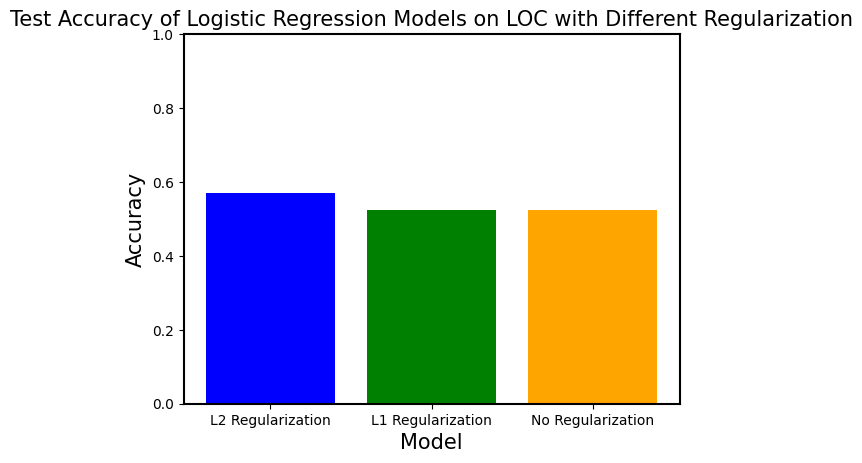

In [8]:
# Compare Different Regulazations L1, L2

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
rndm_state = 7
# L2 Regularization
model_l2 = LogisticRegression(penalty='l2', random_state=rndm_state)
model_l2.fit(X_train, y_train)
acc_l2 = model_l2.score(X_test, y_test)

# L1 Regularization
model_l1 = LogisticRegression(penalty='l1', solver='liblinear', random_state=rndm_state)
model_l1.fit(X_train, y_train)
acc_l1 = model_l1.score(X_test, y_test)

# No Regularization
model_none = LogisticRegression(penalty='none', random_state=rndm_state)
model_none.fit(X_train, y_train)
acc_none = model_none.score(X_test, y_test)

# Print accuracies
print(f"L2 Regularization Accuracy: {acc_l2}")
print(f"L1 Regularization Accuracy: {acc_l1}")
print(f"No Regularization Accuracy: {acc_none}")

# Accuracies
accuracies = [acc_l2, acc_l1, acc_none]
labels = ['L2 Regularization', 'L1 Regularization', 'No Regularization']

# Creating the bar chart
plt.bar(labels, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Test Accuracy of Logistic Regression Models on LOC with Different Regularization')
plt.ylim([0, 1])  # Assuming accuracy is between 0 and 1
plt.show()


#### Single ROI Using SVM

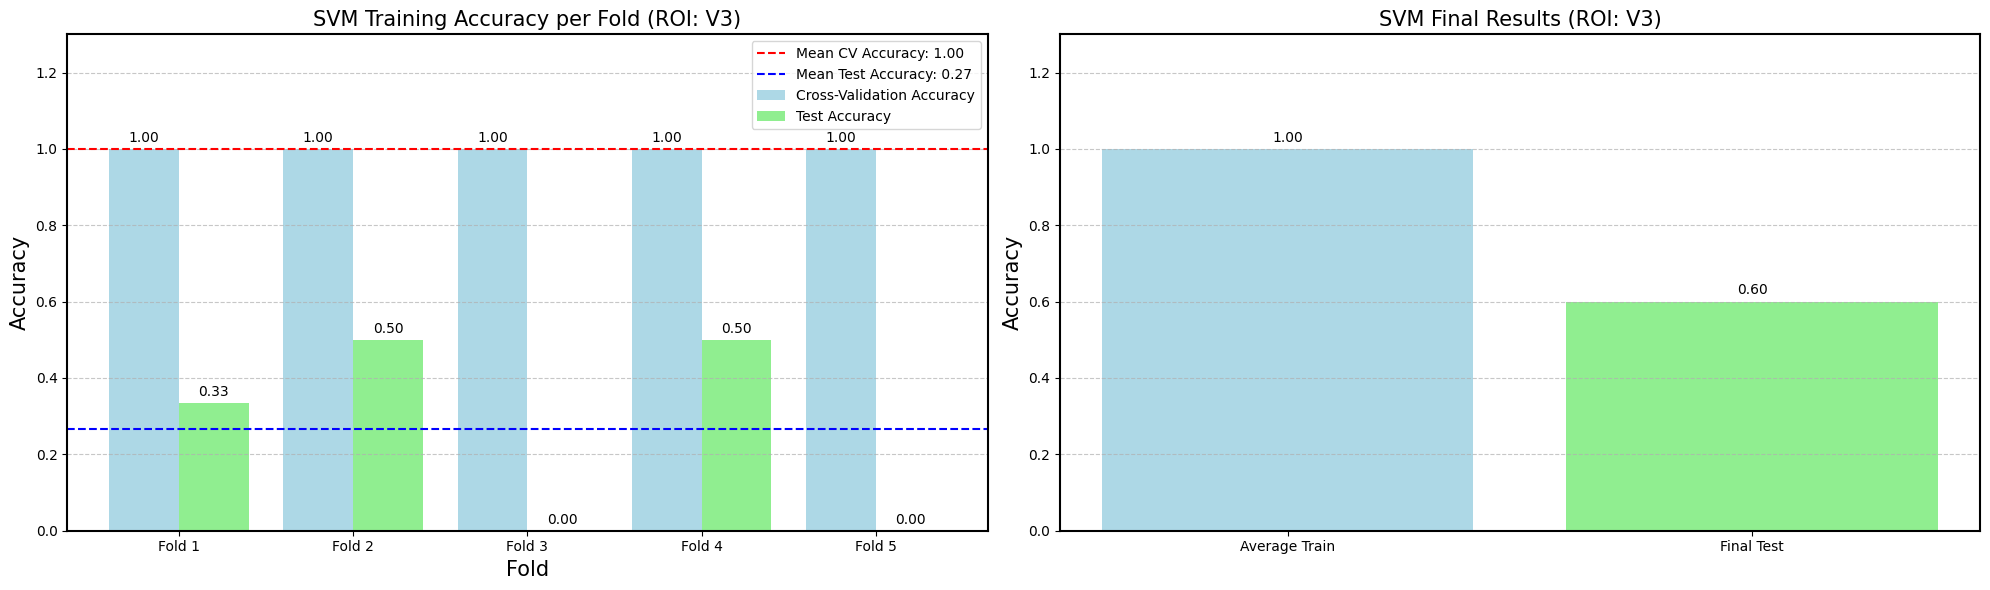

In [11]:
# Region of interest
roi = 'V3'

# Extract data
X, y = extract_data(roi, image_type='different')
y = y.ravel()  # Flatten y to be a 1D array

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.3, random_state=rndm_state)
svm_model = SVC(kernel='linear', random_state=rndm_state)

# Perform cross-validation on the training set
kf = KFold(n_splits=5)
cv_accuracies = []
test_accuracies = []

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    svm_model.fit(X_train_fold, y_train_fold)

    cv_accuracies.append(svm_model.score(X_train_fold, y_train_fold))
    test_accuracies.append(svm_model.score(X_test_fold, y_test_fold))

# Calculate mean accuracies
mean_cv_accuracy = np.mean(cv_accuracies)
mean_test_accuracy = np.mean(test_accuracies)

# Train the final model on the entire training set
svm_model.fit(X_train, y_train)
final_test_accuracy = svm_model.score(X_final_test, y_final_test)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot 1: Cross-validation results
ax1.bar(np.arange(1, 6) - 0.2, cv_accuracies, width=0.4, label='Cross-Validation Accuracy', color='lightblue')
ax1.bar(np.arange(1, 6) + 0.2, test_accuracies, width=0.4, label='Test Accuracy', color='lightgreen')

ax1.set_title(f'SVM Training Accuracy per Fold (ROI: {roi})')
ax1.set_xlabel('Fold')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.3)
ax1.set_xticks(np.arange(1, 6))
ax1.set_xticklabels([f'Fold {i}' for i in range(1, 6)])
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for i, (cv_acc, test_acc) in enumerate(zip(cv_accuracies, test_accuracies), 1):
    ax1.annotate(f'{cv_acc:.2f}', xy=(i-0.2, cv_acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')
    ax1.annotate(f'{test_acc:.2f}', xy=(i+0.2, test_acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

ax1.axhline(mean_cv_accuracy, color='red', linestyle='--', label=f'Mean CV Accuracy: {mean_cv_accuracy:.2f}')
ax1.axhline(mean_test_accuracy, color='blue', linestyle='--', label=f'Mean Test Accuracy: {mean_test_accuracy:.2f}')
ax1.legend()

# Plot 2: Final results
ax2.bar(['Average Train', 'Final Test'], [mean_cv_accuracy, final_test_accuracy], color=['lightblue', 'lightgreen'])
ax2.set_title(f'SVM Final Results (ROI: {roi})')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1.3)
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, acc in enumerate([mean_cv_accuracy, final_test_accuracy]):
    ax2.annotate(f'{acc:.2f}', xy=(i, acc), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### Logistic Regression Across Different ROIs & Different Image Types

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


     accuracy
V1   0.928571
V2   0.928571
V3        1.0
V4   0.571429
LOC  0.785714
FFA  0.642857
PPA  0.642857


Text(0, 0.5, 'Accuracy')

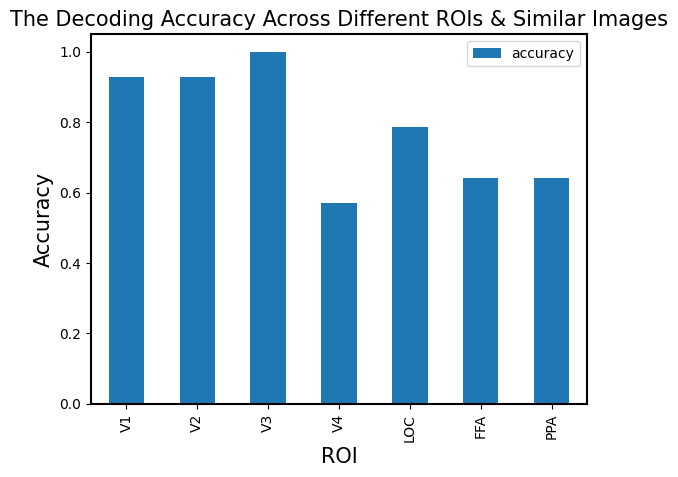

In [13]:
# Code I : visualize the decoding accuracy across different regions of interest
roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
accuracy = pd.DataFrame(index=roi_list, columns=['accuracy'])
for roi in roi_list:
  X, y = extract_data(roi, image_type='similar')
  y = y.ravel() #to convert y to 1-D array
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 7)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy.loc[roi, 'accuracy'] = accuracy_score(y_pred, y_test)

print(accuracy)
accuracy.plot(kind='bar')
plt.title('The Decoding Accuracy Across Different ROIs & Similar Images')
plt.xlabel('ROI')
plt.ylabel('Accuracy')

    accuracy
V1       0.5
V2      0.25
V3       0.5
V4      0.25
LOC     0.75
FFA      0.5
PPA      0.5


Text(0, 0.5, 'Accuracy')

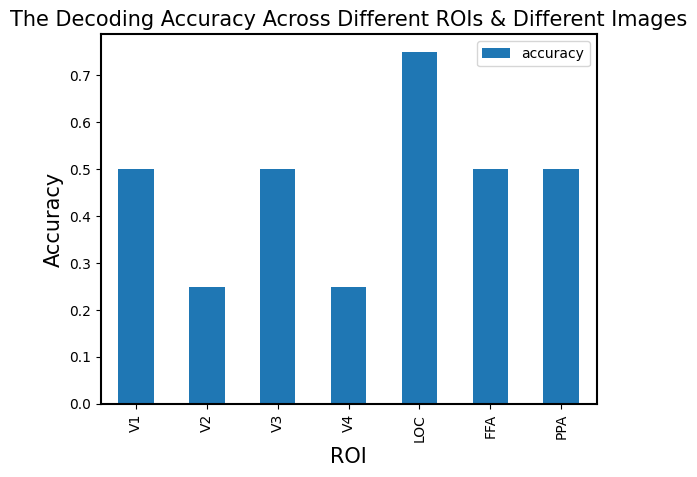

In [14]:
# Code II: repeating the above step but with different images from the same category
roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
accuracy = pd.DataFrame(index=roi_list, columns=['accuracy'])
for roi in roi_list:
  X, y = extract_data(roi, image_type='different')
  y = y.ravel()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 7)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  accuracy.loc[roi, 'accuracy'] = accuracy_score(y_pred, y_test)

print(accuracy)
accuracy.plot(kind='bar')
plt.title('The Decoding Accuracy Across Different ROIs & Different Images')
plt.xlabel('ROI')
plt.ylabel('Accuracy')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Accuracy:
      similar different   imagery
V1   0.927273  0.466667  0.233333
V2   0.910606  0.233333  0.166667
V3   0.874242  0.366667  0.233333
V4   0.681818  0.566667       0.3
LOC  0.662121  0.333333  0.183333
FFA  0.628788  0.666667  0.233333
PPA  0.609091  0.566667  0.433333

Test Set Accuracy:
      similar different imagery
V1   0.928571       0.5     0.0
V2   0.928571      0.25     0.0
V3        1.0       0.5     0.5
V4   0.571429      0.25    0.25
LOC  0.785714      0.75    0.25
FFA  0.642857       0.5    0.25
PPA  0.642857       0.5     0.5


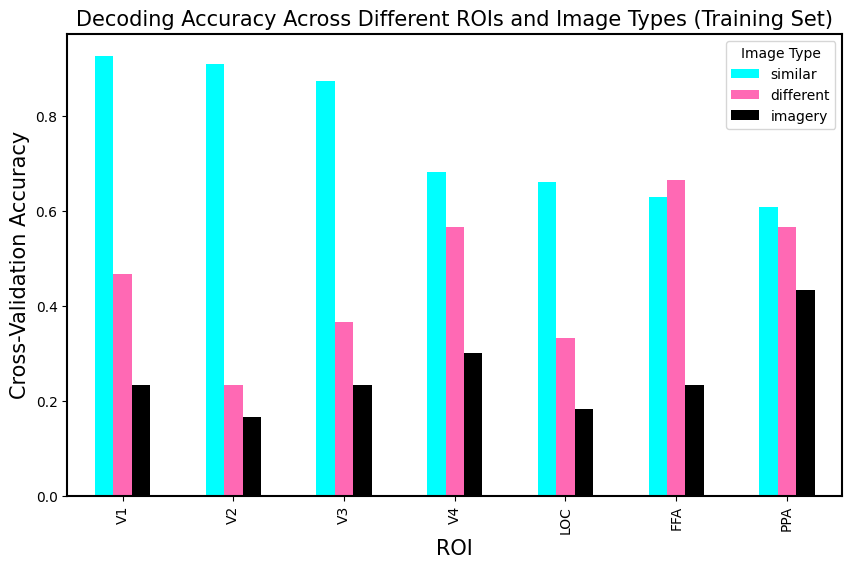

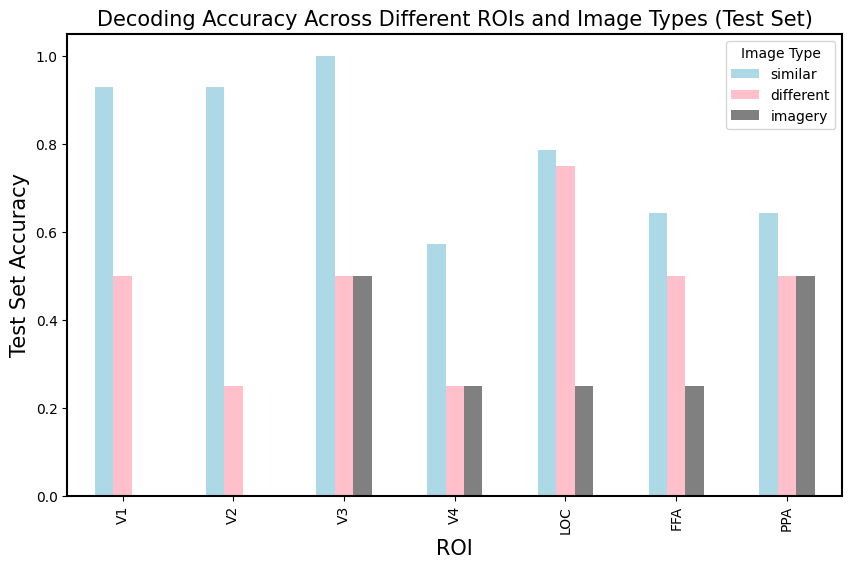

In [15]:
# Code III: Collective Code
# Logestic Regression (using 5-folds on training Data)
# Decoding accuracy across different ROIs and image types > To compare [similar - different - imagery]

roi_list = ['V1', 'V2', 'V3', 'V4', 'LOC', 'FFA', 'PPA']
image_types = ['similar', 'different', 'imagery']
accuracy_cv = pd.DataFrame(index=roi_list, columns=image_types)
accuracy_test = pd.DataFrame(index=roi_list, columns=image_types)
model = LogisticRegression(penalty='l2')

for roi in roi_list:
    for image_type in image_types:
        X, y = extract_data(roi, image_type=image_type)
        y = y.ravel()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

        # Perform cross-validation on the training data
        scores = cross_val_score(model, X_train, y_train, cv=5)
        accuracy_cv.loc[roi, image_type] = scores.mean()

        # Refit the model on the entire training set
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_test.loc[roi, image_type] = accuracy_score(y_test, y_pred)

print("Cross-Validation Accuracy:")
print(accuracy_cv)
print("\nTest Set Accuracy:")
print(accuracy_test)

# Plotting Training (cross-validation) Accuracy
accuracy_cv.plot(kind='bar', figsize=(10, 6), color=['aqua', 'hotpink', 'black'])
plt.title('Decoding Accuracy Across Different ROIs and Image Types (Training Set)')
plt.xlabel('ROI')
plt.ylabel('Cross-Validation Accuracy')
plt.legend(title='Image Type')
plt.show()

# Plotting Test Accuracy
accuracy_test.plot(kind='bar', figsize=(10, 6), color=['lightblue', 'pink', 'gray'])
plt.title('Decoding Accuracy Across Different ROIs and Image Types (Test Set)')
plt.xlabel('ROI')
plt.ylabel('Test Set Accuracy')
plt.legend(title='Image Type')
plt.show()


# References

- Arabs in Neuroscience (AiN) Computaional Neuroscience Summer School Project
- Neuromatch Academy Computational Neuroscience Course
- Kamitani, Yukiyasu, and Frank Tong. "Decoding the visual and subjective contents of the human brain." Nature neuroscience 8.5 (2005): 679-685.
- Horikawa, Tomoyasu, and Yukiyasu Kamitani. "Generic decoding of seen and imagined objects using hierarchical visual features." Nature communications 8.1 (2017): 1-15.
- Shen, Guohua, et al. "Deep image reconstruction from human brain activity." PLoS computational biology 15.1 (2019): e1006633.